In [1]:
import ast
from collections import Counter, defaultdict
import csv
import datetime
import itertools
import math
import numpy
import matplotlib.pyplot as plt
import pandas
from scipy import optimize, stats

%matplotlib inline

I've put the data in tab-separated format. Parsing most of the fields is straightforward, except for `coins`. That field is a string that can be parsed as a JSON or Python list of numbers, and it represents the individual coins that I found that day.

In [2]:
def load_data(filename):
    columns = defaultdict(list)
    with open(filename) as f:
        reader = csv.DictReader(f, delimiter='\t')
        for row in reader:
            row['distance'] = float(row['distance'])
            row['money'] = float(row['money'])
            row['date'] = datetime.datetime.strptime(row['date'], '%Y-%m-%d')
            pace_min, pace_sec = row['pace'].split(':')
            row['pace'] = int(pace_min) + float(pace_sec) / 60
            row['coins'] = ast.literal_eval(row['coins'])
            row['n_coins'] = len(row['coins'])
            for column, value in row.items():
                columns[column].append(value)
    return columns

In [3]:
df = pandas.DataFrame(load_data("data.csv"))

Some basic info

In [4]:
print('Found: ${:0.2f}'.format(df['money'].sum()))
print('Ran: {:0.1f} miles'.format(df['distance'].sum()))

Found: $0.88
Ran: 128.3 miles


First, count how many of each type of coin I found

In [5]:
coin_counts = Counter(itertools.chain(*df['coins']))
coin_types = {1: 'penny', 5: 'nickel', 10: 'dime', 25: 'quarter'}
print({coin_types[coin]: count for coin, count in coin_counts.items()})

{'nickel': 2, 'penny': 18, 'dime': 6}


And how many times I got each count for 4-ish mile runs

In [6]:
four_mile_runs = df.loc[df['distance'].between(3.5, 4.5)]
print(four_mile_runs['n_coins'].value_counts() / len(four_mile_runs['n_coins']))

0    0.833333
4    0.083333
3    0.083333
Name: n_coins, dtype: float64


Create a scatter plot showing how much money I found on each day of the month, normalized for distance. This helps illustrate how much variance there was run-to-run.

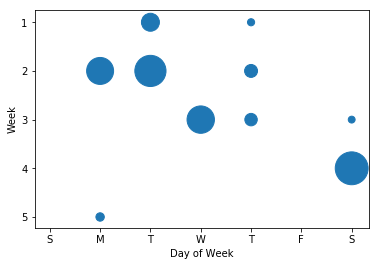

In [7]:
def xy_for_dates(dates):
    """ Convert dates to arrays of x and y coordinates
        that resemble a calendar
    """
    MONTH_STARTS_AT = (1, 4)
    date_delta = numpy.array([_.days for _ in(dates - dates.min())])
    xs = (MONTH_STARTS_AT[0] + date_delta) % 7
    ys = MONTH_STARTS_AT[1] - (date_delta // 7)
    return xs, ys

calendar_points = xy_for_dates(df['date'])
plt.scatter(calendar_points[0], calendar_points[1], s=24000*df['money']/df['distance'])
plt.yticks(range(5), '54321')
plt.ylabel('Week')
plt.xticks(range(7), 'SMTWTFS')
plt.xlabel('Day of Week')

Compute some statistics about the amount of money I found.

In [8]:
mean_money = (df['money']/df['distance']).mean()
std_money = (df['money']/df['distance']).std()
err_on_mean_money = std_money/len(df)
print('Naive cents per mile: {}'.format(df['money'].sum()/df['distance'].sum()))
print('Mean cents per mile: {}'.format(mean_money))
print('Std dev cents per mile: {}'.format(std_money))
print('Error on mean cents per mile: ±{}'.format(err_on_mean_money))

Naive cents per mile: 0.006858924395946999
Mean cents per mile: 0.006239611609959081
Std dev cents per mile: 0.012980262101722092
Error on mean cents per mile: ±0.0004475952448869687


Compute some statistics about the number of coins I found.

In [9]:
mean_coins = (df['n_coins']/df['distance']).mean()
std_coins = (df['n_coins']/df['distance']).std()
err_on_mean_coins = std_coins/len(df)
print('Naive coins per mile: {}'.format(df['n_coins'].sum()/df['distance'].sum()))
print('Mean coins per mile: {}'.format(mean_coins))
print('Std dev coins per mile: {}'.format(std_coins))
print('Error on mean cents per mile: ±{}'.format(err_on_mean_coins))

Naive coins per mile: 0.20265003897116132
Mean coins per mile: 0.183297657832405
Std dev coins per mile: 0.3158796899802083
Error on mean cents per mile: ±0.010892403102765805


If I just look at mean and standard deviation, that's misleading. I shouldn't ever be finding negative money.

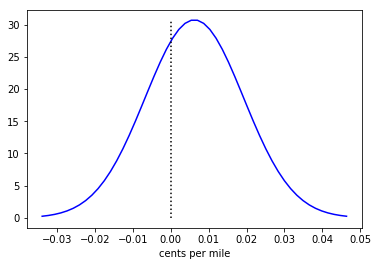

In [10]:
norm = stats.norm(loc=mean_money, scale=std_money)
pdf_x = numpy.linspace(norm.ppf(0.001), norm.ppf(0.999))
pdf_y = norm.pdf(pdf_x)
plt.plot(pdf_x, pdf_y, 'b-')
plt.plot([0, 0], [0, pdf_y.max()], 'k:')
plt.xlabel('cents per mile')

In [11]:
lose_money_percent = 100 * norm.cdf(0)
print('Lose money {:0.1f}% of the time'.format(lose_money_percent))

Lose money 31.5% of the time


The maximum likelihood fit for the Poisson distribution should be the same the mean naive coins per mile above.

In [12]:
def poisson_nll(l, d, n):
    return -numpy.log(stats.poisson.pmf(n, d * l)).sum()

def poisson_nll_simple(l, d, n):
    return (l * d).sum() - (n * numpy.log(l * d)).sum()

res = optimize.minimize(poisson_nll_simple, [mean_coins], args=(df['distance'], df['n_coins']))
print('Maximum likelihood fit coins/mile:')
print(res)
print('Compare to mean coins/mile: {}'.format(mean_coins))
print('Compare to naive coins/mile: {}'.format(df['n_coins'].sum()/df['distance'].sum()))

Maximum likelihood fit coins/mile:
      fun: 24.705554171137617
 hess_inv: array([[ 0.00157972]])
      jac: array([ -9.53674316e-07])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 3
     njev: 6
   status: 0
  success: True
        x: array([ 0.20265003])
Compare to mean coins/mile: 0.183297657832405
Compare to naive coins/mile: 0.20265003897116132


Scan the parameter to find a confidence interval.

In [13]:
lambda_best = res.x[0]
nll_at_best = res.fun

# confidence_level = stats.chi2.cdf(1, df=1)  # 68.3%
confidence_level = 0.95

delta_chi_sq = stats.chi2.ppf(confidence_level, df=1)
delta_nll = 0.5 * delta_chi_sq

lambda_lo = 0
lambda_hi = 0
for l in numpy.linspace(1e-10, lambda_best):
    if poisson_nll_simple(l, df['distance'], df['n_coins']) > nll_at_best + delta_nll:
        lambda_lo = l
    if poisson_nll_simple(2*lambda_best - l, df['distance'], df['n_coins']) > nll_at_best + delta_nll:
        lambda_hi = 2*lambda_best - l

print('Confidence interval: ({}, {})'.format(lambda_lo, lambda_hi))
print('Cents per mile: {} +{}/-{}'.format(lambda_best, lambda_hi - lambda_best, lambda_best - lambda_lo))


Confidence interval: (0.13234287724296775, 0.29363575876095965)
Cents per mile: 0.20265003072516935 +0.0909857280357903/-0.0703071534822016


What happens on a typical run?

In [14]:
RUN_LENGTH = 4  # miles
COIN_MAX = 2
dist = stats.poisson(RUN_LENGTH * lambda_best)
for i in range(COIN_MAX + 1):
    print('Find {} coins {:0.1f}%'.format(i, 100*dist.pmf(i)))
print('Find more than {} coins {:0.1f}%'.format(COIN_MAX, 100 * (1 - dist.cdf(COIN_MAX))))
print('')
print('On low end of CI, find 0 coins {:0.1f}%'.format(100*stats.poisson(RUN_LENGTH * lambda_lo).pmf(0)))

Find 0 coins 44.5%
Find 1 coins 36.0%
Find 2 coins 14.6%
Find more than 2 coins 4.9%

On low end of CI, find 0 coins 58.9%


Draw a histogram

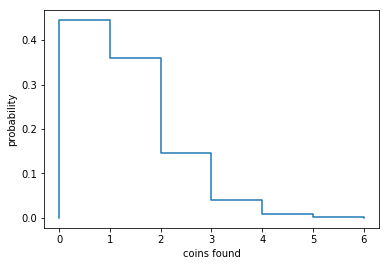

In [15]:
pmf_x = [0]
pmf_y = [0]
for i in range(6):
    pmf_x.extend([i, i + 1])
    p = dist.pmf(i)
    pmf_y.extend([p, p])
pmf_x.append(i + 1)
pmf_y.append(0)
plt.plot(pmf_x, pmf_y)
plt.xlabel('coins found')
plt.ylabel('probability')

Simulate to see if the Poisson model is close to reality. Sample from the distances I actually ran and Poisson select a number of coins thousands of times. Plot cumulative histograms of coins normalized for distance.

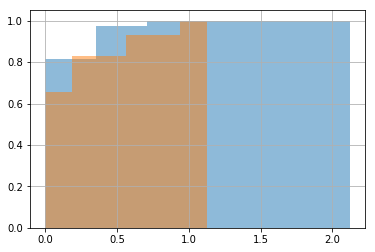

In [16]:
N_SIM = 10000
sim_distances = numpy.random.choice(df['distance'], N_SIM)
sim_coins = [numpy.random.poisson(lambda_best * d) for d in sim_distances]
sim_df = pandas.DataFrame({'distance': sim_distances, 'n_coins': sim_coins})

(sim_df['n_coins'] / sim_df['distance']).hist(cumulative=True, normed=True, bins=6, alpha=0.5)
(df['n_coins'] / df['distance']).hist(cumulative=True, normed=True, bins=6, alpha=0.5)


Extrapolate out to a year

In [17]:
MILES_PER_YEAR = 2000
n_coins_year = int(lambda_best * MILES_PER_YEAR)
print('in a year of {} miles, find {} coins on average'.format(MILES_PER_YEAR, n_coins_year))
print('on average, make ${:0.2f}'.format(n_coins_year*df['money'].mean()))

in a year of 2000 miles, find 405 coins on average
on average, make $12.29


For curiosity, do a linear fit and see how that looks. Constrain y-intercept to 0, since we don't get free money walking out the door (alas).

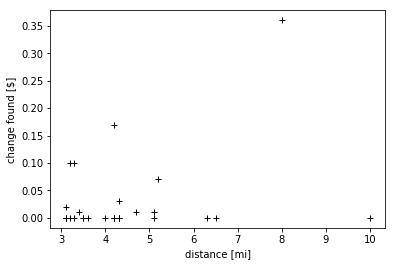

In [18]:
df = df.sort_values('distance')
plt.plot(df['distance'], df['money'], 'k+')
plt.xlabel('distance [mi]')
plt.ylabel('change found [$]')

In [19]:
def linear(x, a0):
    return 0 + a0*x

In [20]:
a, cov = optimize.curve_fit(linear, df['distance'], df['money'])

95% confidence intervals on parameters

In [21]:
a_err = [1.96 * math.sqrt(cov[i][i]) for i in range(len(a))]

In [22]:
print('Best estimate: ({a[0]:.4f} ± {a_err[0]:.4f})x'.format(a=a, a_err=a_err))

Best estimate: (0.0077 ± 0.0056)x


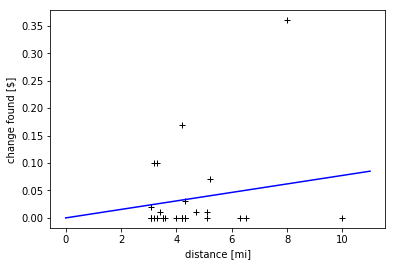

In [23]:
x = numpy.linspace(0, 1.1*df['distance'].max())
y = 0 + a[0]*x
plt.plot(df['distance'], df['money'], 'k+')
plt.plot(x, y, 'b-')
plt.xlabel('distance [mi]')
plt.ylabel('change found [$]')